# **Unet in MNIST**#

---
#![alt text](https://drive.google.com/uc?id=1xlj2KFK3C6ESffAV5PcjPf8KHCliDvrT)
---

# **Initialisation**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import numpy as np
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
import copy


# **Dataset creation on MNIST data**


**List of steps for creating dataset**

*   Creating the image of size 128x128 
*   Inserting the 9 random MNIST image and avoid creating overlap
*   Creating the target mask image matching the train data 



**Download & extract mnist data set from git**

In [ ]:
!git clone http://github.com/pytorch/examples
os.chdir('examples/mnist')


Cloning into 'examples'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2474 (delta 0), reused 1 (delta 0), pack-reused 2469
Receiving objects: 100% (2474/2474), 39.07 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (1228/1228), done.


**Downloading the MNIST data and storing it in variable**

In [ ]:
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

trainset = train_set.data.numpy()
testset = test_set.data.numpy()
train_labels = train_set.train_labels.numpy()
test_labels = test_set.test_labels.numpy()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


**Dataset creation for train and target images**

In [ ]:
MNIST_SIZE       = 28   # MNIST image size
MNIST_NUM_CLASS  = 10   # Number of classes in MNIST (digits 0 to 9)
IMAGE_SIZE       = 128  # Segmentation data image size we will create
TRAIN_DATA_SIZE  = 5000 # Number of images in the whole train data
TEST_DATA_SIZE   = 1000 # Number of images in the whole test  data

# Create segmentation data set ... image, label, and weights
def data_generation(big_image, big_label, num_digits=9, train=True):
    source = trainset
    source_labels = train_labels
    if not train:
        source = testset
        source_labels = test_labels
    
    image_size = big_image.shape[0]
    label = np.zeros([MNIST_SIZE]*2,dtype=np.float32)
    temp_image = big_image
    temp_image.fill(0)

    for _ in range(num_digits):
        index = np.random.randint(0,len(source))
        image = source[index]
        image = image.reshape([MNIST_SIZE]*2)


        label.fill(10)
        label_val = source_labels[index]
        label[np.where(image>0)] = label_val

        for _ in range(200):
          x_pos = int(np.random.randint(0,image_size-MNIST_SIZE))
          y_pos = int(np.random.randint(0,image_size-MNIST_SIZE))
          if np.sum(temp_image[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE]) == 0:
             temp_image[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE] = np.ones((28,28))
             break
        big_image[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE] += image
   
        label_crop = big_label[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE]
        label_crop[label<label_crop] = label_val

# Create a whole segmentation data set for train/test
def segment_data(data_size=5500,image_size=128,num_digits=9,train=True):
    print('Generating {data_size} images...'.format(data_size=data_size))  
    images  = np.zeros([data_size,image_size,image_size],dtype=np.float32)
    labels  = np.zeros([data_size,image_size,image_size],dtype=np.int64)
    labels.fill(10)
    for _ in range(data_size):
        image  = images  [_]
        label  = labels  [_]
        data_generation(image,label,num_digits,train=train)
    print('done!')
    return images, labels


train_images, train_la = segment_data(TRAIN_DATA_SIZE, train=True)
val_images, val_la = segment_data(200, train=True)
test_images,  test_la  = segment_data(TEST_DATA_SIZE,  train=False)

Generating 5000 images...
done!
Generating 200 images...
done!
Generating 1000 images...
done!


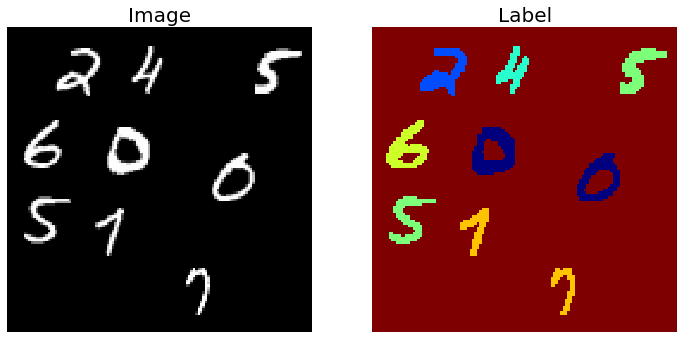

In [ ]:
## Visualize a random entry
index = np.random.randint(0,len(val_images))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12),facecolor='w')
ax1.imshow(val_images[index],  interpolation='none',cmap='gray')
ax2.imshow(val_la[index],  interpolation='none',cmap='jet')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Image',fontsize=20)
ax2.set_title('Label',fontsize=20)
plt.show()

**Images to dataloader pytorch**

In [ ]:
#Covert Numpy to tensorflow
traindataset = torch.utils.data.TensorDataset(torch.Tensor(train_images),torch.Tensor(train_la))
valdataset = torch.utils.data.TensorDataset(torch.Tensor(val_images),torch.Tensor(val_la))
testdataset = torch.utils.data.TensorDataset(torch.Tensor(test_images),torch.Tensor(test_la))

image_datasets = {'train': traindataset, 'val': valdataset}

batch_size = 25

# creating data loader for train, val and test
dataloaders = {
    'train': torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(valdataset, batch_size=1, shuffle=True, num_workers=0),
    'test' : torch.utils.data.DataLoader(testdataset,batch_size=1, shuffle=True, num_workers=0)
}

# **Model creation**#

**Input size of image** : (1, 128, 128)

**Input type** : Tensor

**Output size of image** : (11, 128, 128) -> **Channel information:** pedestrian and background

**List of Unet models created for studies. Categorised based on parameters**

*   unet_7M_mnist - 7,782,978 parameters
*   unet_3M_mnist - 3,873,986 parameters
*   unet_100k_mnist - 138000 parameters 
*   unet_78k_mnist - 78,802 parameters
*   unet_16k_mnist - 16,178 parameters


**Models 7M Parameters**

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )   

def upsample_conv(in_channels):
  return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)

class unet_7M_mnist(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        #self.upsample1 = upsample_conv(10)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class,1, stride=1)

    def upsample_conv(in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])         
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        #out = self.softmax(out)
        
        return out

# Checking the GPU availability
gpu_available = torch.cuda.is_available() #checking GPU availability
print("GPU available: " + str(gpu_available))

n_class = 11
Unet = unet_7M_mnist(n_class) 
if gpu_available:
    unet = Unet.cuda()

GPU available: True


**Models 3M Parameters**

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
    )   

def upsample_conv(in_channels):
  return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)

class unet_3M_mnist(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        #self.upsample1 = upsample_conv(10)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class,1, stride=1)

    def upsample_conv(in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)
        #x = self.upsample_conv(x.shape[1])         
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        #out = self.softmax(out)
        
        return out

# Checking the GPU availability
gpu_available = torch.cuda.is_available() #checking GPU availability
print("GPU available: " + str(gpu_available))

n_class = 11
Unet = unet_3M_mnist(n_class) 
if gpu_available:
    unet = Unet.cuda()


GPU available: True


**Models 100k parameters**


In [ ]:
# Defining the unet for Mnist toy dataset>>> Input 128*128*1
class unet_100k_mnist(nn.Module):
  def __init__(self, n_class):
    super(unet_100k_mnist,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(1, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1, dilation=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0, dilation=1)
    self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0, dilation=1)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, n_class, 1, stride=1)
    #self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   

# Checking the GPU availability
gpu_available = torch.cuda.is_available() #checking GPU availability
print("GPU available: " + str(gpu_available))
n_class = 11
Unet = unet_100k_mnist(n_class) 
if gpu_available:
    unet = Unet.cuda()

GPU available: True


**Model 78k parameters**


In [ ]:
# Defining the unet for Mnist toy dataset>>> Input 128*128*1
class unet_78k_mnist(nn.Module):
  def __init__(self, n_class):
    super(unet_78k_mnist,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(1, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0, dilation=1)
    self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0, dilation=1)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, n_class, 1, stride=1)
    #self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      #x11 = self.softmax(x10)
      return x10   

# Checking the GPU availability
gpu_available = torch.cuda.is_available() #checking GPU availability
print("GPU available: " + str(gpu_available))
n_class = 11
Unet = unet_78k_mnist(n_class) 
if gpu_available:
    unet = Unet.cuda()

GPU available: True


**Model 16k parameters**

In [ ]:
# Defining the unet for Mnist toy dataset>>> Input 128*128*1
class unet_16k_mnist(nn.Module):
  def __init__(self, n_class):
    super(unet_16k_mnist,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(1, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    #self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    #self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0, dilation=1)
    #self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0, dilation=1)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1, dilation=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, n_class, 1, stride=1)
    #self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      #x4 = self.downsampling(x3)
      #x5 = self.contractinglayer3(x4)
      #x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      #x7 = self.explayer4(x6)
      x5 = torch.cat([self.upsampling_2to1(x3,output_size=x1.size()), x1], dim=1)
      x6 = self.explayer5(x5)
      x7 = self.output_conv(x6)
      #x11 = self.softmax(x10)
      return x7   

# Checking the GPU availability
gpu_available = torch.cuda.is_available() #checking GPU availability
print("GPU available: " + str(gpu_available))
n_class = 11
Unet = unet_16k_mnist(n_class) 
if gpu_available:
    unet = Unet.cuda()

GPU available: True


# **Information to be set**

Requires input from the user

In [ ]:
picking_architecture = 0 #user input to choose architecture
num_epochs =50 # enter number of epochs

unetslist = [unet_7M_mnist(n_class),unet_3M_mnist(n_class),unet_100k_mnist(n_class),unet_78k_mnist(n_class),unet_16k_mnist(n_class)] # to select the model to train
unetsavelist = ["unet_7M_mnist.pth","unet_3M_mnist.pth","unet_100k_mnist.pth","unet_78k_mnist.pth","unet_16k_mnist.pth"] # to save the model

**Function for splitting the masking labels to channel required for training**

In [ ]:
def label_split(labels,targetimage,n_class):
  for i in range(n_class):
    if i==0:
      labels[:,0,:,:] = (targetimage== 0)==1
    else:
        labels[:,i,:,:] = (targetimage!= i)==0
  return labels


# **Loss function**

**Using Dice loss with BCE loss**

**Dice loss function**

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

**IOU loss function**

In [ ]:
def iou(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    iou1 = ((intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth - intersection))
    
    return iou1.mean()

**Combining Dice loss with Binary cross entropy loss**

In [ ]:
from collections import defaultdict
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

#from loss import dice_loss

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target).type(dtype)

    pred = F.sigmoid(pred).type(dtype)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))



# **Optimizer**

In [ ]:
#Training

running_loss = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
n_class = 11
unet = unetslist[picking_architecture]
gpu_available = torch.cuda.is_available() 
if gpu_available:
    unet = unet.cuda()


model = unet


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


cuda:0


# **Training**

In [ ]:
    loss_values =[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            #metrics = defaultdict(float)
            epoch_samples = 0

            for i, data in enumerate(dataloaders[phase]):
                inputs, targetimage = data
                inputs = inputs.unsqueeze(1).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    lab_channel = torch.empty_like(outputs)
                    lab_channel = label_split(lab_channel, targetimage, n_class).cuda()
                    loss = calc_loss(outputs, lab_channel)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                running_loss += loss.item()
                if i % 10 == 9:    
                  print('[%d] loss: %.3f',(epoch + 1, running_loss / 100))
                  loss_values.append(running_loss / len(trainset))
                  running_loss = 0.0

        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


**Dont run the save command if the training is not performed**

In [ ]:
# Linking the google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
torch.save(unet.state_dict(), os.path.join("/content/drive/My Drive/Dataset/mnist_segmentation",unetsavelist[picking_architecture]))

# **Testing**

**Load the pretrained dataset here if available**

**Note:**

* Ensure the directory is correct to search the .pth file
* Ensure correct name for .pth file matching the choosen model architecture
* If architecture matched we will see: **All keys matched successfully**

In [ ]:
unet.load_state_dict(torch.load(os.path.join("/content/drive/My Drive/Dataset/mnist_segmentation",unetsavelist[picking_architecture])))

<All keys matched successfully>

**Checking the IOU for our test set**

Change the Iou threshold if needed

In [ ]:
iou_threshold = [0.1,0.5,0.75,0.9]

#Testing the Model
accuracy_list = []
for j,thres in enumerate(iou_threshold):
  num = 0
  tnum = 0
  iou1 = 0
  niou = 0
  for i, data in enumerate(dataloaders['test']):
    tnum = tnum + 1
    inputs, targetimage = data
    if gpu_available:
      inputs = inputs.unsqueeze(1).cuda()
    pred = model(inputs)
    pred = torch.sigmoid(pred)
    lab_channel = torch.empty_like(pred)
    lab_channel = label_split(lab_channel, targetimage, n_class).cuda()
    iou1= iou(pred, lab_channel)
    if iou1 > thres:
      num = num + 1


  accuracy = (num / tnum) * 100;
  accuracy_list.append(accuracy)

print("Accuracy of the model is :",accuracy_list)

Accuracy of the model is : [100.0, 100.0, 99.8, 92.80000000000001]


**Visualising the predicted output**

torch.Size([1, 11, 128, 128])
torch.Size([1, 128, 128])


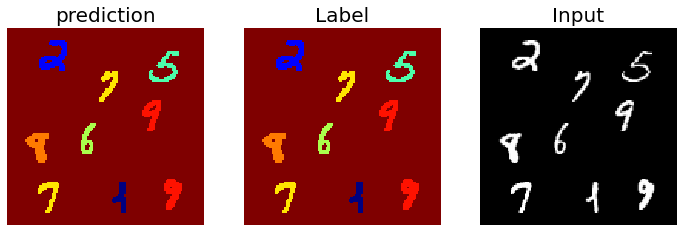

In [ ]:
import math

# Get the first batch
inputs1, targetimage = next(iter(dataloaders['val']))
inputs = inputs1.unsqueeze(1).cuda()

# Predict
pred = model(inputs)

# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred_max = torch.argmax(pred, dim=1)


print(pred.shape)
print(targetimage.shape)


#printing image
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
ax1.imshow(pred_max.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax2.imshow(targetimage.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax3.imshow(inputs1.squeeze(0).cpu(),  interpolation='none',cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('prediction',fontsize=20)
ax2.set_title('Label',fontsize=20)
ax3.set_title('Input',fontsize=20)
plt.show()

